## Novelty

In [45]:
import pandas as pd

# Load sampled data
all_events = pd.read_csv('../data/RetailRocket/sorted_events.csv')

[]

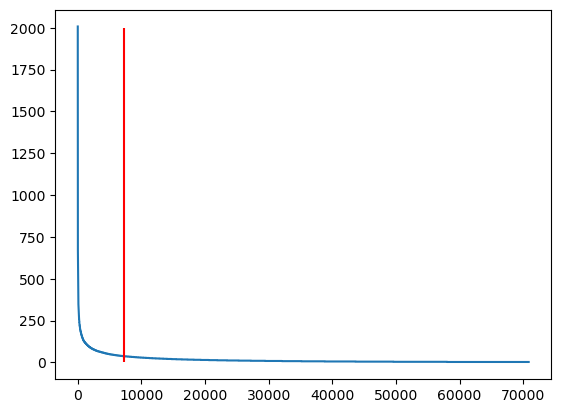

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Plot item frequency with 90% quantile
freqs = all_events.item_id.value_counts().sort_values(ascending=False)
quant = np.quantile(freqs, q=0.9)
idx_first_smaller = np.argmax(freqs < quant)
plt.plot(range(len(all_events.item_id.unique())), freqs)
plt.vlines(x=idx_first_smaller, ymin=0, ymax=2000, colors="r")
#plt.ylim(0,30)
plt.plot()

In [3]:
len(all_events.item_id.unique())  # 70852 items

70852

In [4]:
# Check on GPU!
freqs = all_events.item_id.value_counts().sort_values(ascending=False)
quant = np.quantile(freqs, q=0.9)
freqs[freqs<quant].index.values

array([60408, 13988, 37540, ..., 51933, 50544,  1368])

In [5]:
(freqs<quant)[70075]

False

In [6]:
import pathlib
"df" in str(pathlib.Path("../data/RetailRocket/data_statis.df").absolute())

True

In [2]:

from recommenders.data_utils.item_frequency import load_unpopular_items
data_path = "../data/SMORL-RetailRocket/unpopular_items.pkl"
unpop_set = load_unpopular_items(data_dir=data_path)
len(unpop_set)

63562

In [8]:
# Check if included
import torch 
a = torch.tensor([[1,2,3,4], [10,11,12,13],[-1,-1,-1,1]])

In [9]:
#%%timeit
def compare(array, l):
    return array in l
func = np.vectorize(compare, excluded=["l"])
res =func(a, l=less_popular_items).astype(int)
np.mean(res, axis=1)

array([1.  , 1.  , 0.25])

## Diversity

In the paper they use only the top prediction to get the diversity reward. Let's integrate at least an option asame for novelty to get the average reward based on the topX preds. 

In [13]:
# Load it and use it for diversity computation
import torch
emb = torch.nn.Embedding.from_pretrained(torch.load("../experiments/GRU4Rec/GRU_end_opt1/embedding_weights.pt"), freeze=True)

In [14]:
# Gather the right values
state_back = torch.tensor([[1,2,3,4,0,0], [12,13,14,0,0,0]])
state_back.gather(index=torch.tensor([3,2]).unsqueeze(1), dim=1)

tensor([[ 4],
        [14]])

In [15]:
preds = torch.tensor([[100, 50, 0, 0, 0], [100, -10, 10, 0, 0]])
state_front = torch.tensor([[0,0,1,2,3,3], [0,0,0,12,13,2]])
state_back = torch.tensor([[1,2,3,3,0,0], [12,13,2,0,0,0]])
leng = torch.tensor([4,3])

# Extract last click from state
def get_last_action(s, padding_pos, s_len=None):
    if padding_pos=="end":
        idx=s_len-1
        return s.gather(index=idx.unsqueeze(1), dim=1).squeeze()
    else:
        return s[:,-1]
    
print(get_last_action(state_back, padding_pos="end", s_len=leng))
print(get_last_action(s=state_front, padding_pos="beg", ))

tensor([3, 2])
tensor([3, 2])


In [35]:
# Cosine similarity as in paper
sim = torch.nn.CosineSimilarity(dim=2, eps=1e-6)

preds = torch.tensor([[100, 50, 0,25], [0,3,2, 1]])
last_a = get_last_action(state_back, padding_pos="end", s_len=leng)
print(last_a)
#last_a = torch.tensor([ 3, 2])
embedded_last_a = emb(last_a)  # (bs, emb_s)

_, preds_1 = torch.topk(preds, k=1)
_, preds_3 = torch.topk(preds, k=3)
embedded_preds_top1 = emb(preds_1)
embedded_preds_top3 = emb(preds_3)  # top3
print(embedded_last_a.shape)
print(embedded_preds_top3.shape)

res_top3 = sim(embedded_last_a.unsqueeze(1), embedded_preds_top3)  
res_top1 = sim(embedded_last_a.unsqueeze(1), embedded_preds_top1)  
print(res_top3)
print(res_top1)
# Output represents cosine sim for each of topk preds to last action in each batch!
# cos_sim((batch_size, 1, embedding_dim), (batch_size, topk, embedding_dim)) -> (batch_size, topk)

tensor([3, 2])
torch.Size([2, 64])
torch.Size([2, 3, 64])
tensor([[ 0.0163,  0.0192,  1.0000],
        [-0.2763,  1.0000, -0.1198]])
tensor([[ 0.0163],
        [-0.2763]])


In [41]:
1-torch.mean(res_top1, dim=1)

tensor([0.9837, 1.2763])

In [39]:
from recommenders.evaluate.diversity import get_batch_diversity_rewards
emb.to("cpu")
get_batch_diversity_rewards(state_back, preds, len_states=leng, padding_pos="end", topk_to_consider=1, embedding_layer=emb)

tensor([0.9837, 1.2763])

In [20]:
import numpy as np
a = embedded_last_a[0,:]
b = embedded_preds[1, 1,:]
np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))

0.03535191

In [21]:
import numpy as np
a = embedded_last_a[0,:]
b = embedded_preds[1, 1,:]
np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))

0.03535191

In [22]:
simila = sim(embedded_last_a.unsqueeze(1), embedded_preds)
print(simila)

# Avergae 
1- torch.mean(simila, dim=1)

tensor([[0.1661, 0.2022, 1.0000],
        [0.0166, 1.0000, 0.0354]])


tensor([0.5439, 0.6494])

In [23]:
preds = torch.tensor([[30, 20, 5,10], [0, 10,5, 2]])

def get_batch_diversity_rewards(s, predictions, len_states, padding_pos, topk_to_consider, embedding_layer):
    # Init cosine similarity func
    cos_sim = torch.nn.CosineSimilarity(dim=2, eps=1e-6)

    # Get tensor (batch_size) of last actions
    last_actions = get_last_action(s=s, padding_pos=padding_pos, s_len=len_states)

    # Choose topk preds to consider
    _, action_idx = torch.topk(predictions, k=topk_to_consider)

    # Embed last action and predicted actions
    embed_last_a = embedding_layer(last_actions).unsqueeze(1)
    embed_preds = embedding_layer(action_idx)

    # Get similarity [-1, 1] so r [0, 2]
    similarity = cos_sim(embed_last_a, embed_preds)

    # Take mean over rows to get avg sim of top preds to last a
    mean_sim = torch.mean(similarity, dim=1)
    batch_rewards = 1 - mean_sim

    return batch_rewards

get_batch_diversity_rewards(state_back, preds, len, padding_pos="end", topk_to_consider=3, embedding_layer=emb)

TypeError: unsupported operand type(s) for -: 'builtin_function_or_method' and 'int'

## Coverage

In [24]:
a = set([1,2,3]).union(set([-1]))
-1 in a

True

In [92]:
unique_top20 = set([1,2,3,10,20,30])
allc = [1,2,3,4,5,10,20,30,40,50]
unpop = set([1,2,3,4,5])
item_num = 10

def get_coverage(unique_topk_actions, unpopular_items, num_actions):
    """
    Compute coverage for a given set of unique top-k actions accumulated 
    over the whole epoch (either during training or during evaluation). 

    Important: dtype is set here.
    """
    assert isinstance(unique_topk_actions, set) & isinstance(unpopular_items, set)

    # Intersect the two sets and return percentages
    intersect_unpop = unique_topk_actions.intersection(unpopular_items)
    unpopular_coverage = len(intersect_unpop)/len(unpopular_items)
    all_coverage = len(unique_topk_actions)/num_actions

    return unpopular_coverage, all_coverage

get_coverage(unique_top20, unpop, num_actions=10)

(0.6, 0.6)

## Repetition

Different definition compared to paper. In the paper they loop over the evaluation/test set and compute the average repetitions@k per session. We cannot do that since the loader does not yield session ids and it is not useful/representative in general I would say. The sessions are still sampled by the old agent - no influence on next states. You measure offline repetition but in reality we would need online repetition. Maybe later on can be tested with simulation? 

What we measure: Just based on the evaluation trajectories, in total how many % of the shown items were repetitions?
We could do that but a loooot of overhead - yield session_id in loader, keep track of all unique_items per session, ...

195K extra vals. Let's just do simulation!

Choose arbitrary val

In [52]:
pass

## SMORL preprocessing and ReplayBuffer

In [2]:
import pandas as pd 

#df_all = pd.read_pickle("../data/SMORL-RetailRocket/sorted_events.df")
df_train = pd.read_pickle("../data/RetailRocket/sampled_train.df")
#df_val = pd.read_pickle("../data/SMORL-RetailRocket/sampled_val.df")
#df_test = pd.read_pickle("../data/SMORL-RetailRocket/sampled_test.df")

In [8]:
df_train["reward"] = 0
df_train.reward[df_train.is_buy==1] = 1
df_train.reward[df_train.is_buy==0] = 0.2
df_train[df_train.is_buy==1].head()

,timestamp,session_id,item_id,is_buy,reward
1133190,1440914628202,2,9750,1,1.0
1357916,1441951937583,20,68635,1,1.0
1368056,1441951967871,20,27419,1,1.0
1367869,1441952264613,20,6210,1,1.0
1366578,1442032680026,20,59354,1,1.0


In [9]:
# Add reward column - action types are not differentiated
#df_all["reward"] = 1
# df_train["reward"] = 1
#df_val["reward"] = 1
#df_test["reward"] = 1
#df_all.to_pickle("../data/SMORL-RetailRocket/sorted_events_with_rew.df")
df_train.to_pickle("../data/SMORL-RetailRocket/sampled_train_with_OGPAPER_rew.df")
#df_val.to_pickle("../data/SMORL-RetailRocket/sampled_val_with_rew.df")
#df_test.to_pickle("../data/SMORL-RetailRocket/sampled_test_with_rew.df")

In [4]:
import pandas as pd
#pd.read_pickle("../data/SMORL-RetailRocket/replay_buffer_end_OGPaperRew.df")

In [6]:
# !python scripts/replay_buffer_SMORL_from_file.py -f data/SMORL-RetailRocket/sampled_train_with_rew.df -p end -n replay_buffer_end

python: can't open file '/local/data1/pathi619/Recomender-Models/notebooks/scripts/replay_buffer_SMORL_from_file.py': [Errno 2] No such file or directory


In [ ]:
# python src/data_utils/item_frequency.py -f data/RetailRocket/sorted_events.df -t data/SMORL-RetailRocket/ -q 0.9 -i item_id

In [2]:
import pandas as pd
rp1 = pd.read_pickle("../data/SMORL-RetailRocket/replay_buffer_end_OGPaperRew.df")
rp2 = pd.read_pickle("../data/SMORL-RetailRocket/replay_buffer_end.df")

In [3]:
rp1.head()

,state,action,r_act,next_state,true_state_len,true_next_state_len,is_end
742616,"[70852, 70852, 70852, 70852, 70852, 70852, 708...",49432,0.2,"[49432, 70852, 70852, 70852, 70852, 70852, 708...",1,1,False
735273,"[49432, 70852, 70852, 70852, 70852, 70852, 708...",49432,0.2,"[49432, 49432, 70852, 70852, 70852, 70852, 708...",1,2,False
737711,"[49432, 49432, 70852, 70852, 70852, 70852, 708...",39563,0.2,"[49432, 49432, 39563, 70852, 70852, 70852, 708...",2,3,False
726292,"[49432, 49432, 39563, 70852, 70852, 70852, 708...",32776,0.2,"[49432, 49432, 39563, 32776, 70852, 70852, 708...",3,4,False
737615,"[49432, 49432, 39563, 32776, 70852, 70852, 708...",52161,0.2,"[49432, 49432, 39563, 32776, 52161, 70852, 708...",4,5,False


In [4]:
rp2.head()

,state,action,r_act,next_state,true_state_len,true_next_state_len,is_end
742616,"[70852, 70852, 70852, 70852, 70852, 70852, 708...",49432,1,"[49432, 70852, 70852, 70852, 70852, 70852, 708...",1,1,False
735273,"[49432, 70852, 70852, 70852, 70852, 70852, 708...",49432,1,"[49432, 49432, 70852, 70852, 70852, 70852, 708...",1,2,False
737711,"[49432, 49432, 70852, 70852, 70852, 70852, 708...",39563,1,"[49432, 49432, 39563, 70852, 70852, 70852, 708...",2,3,False
726292,"[49432, 49432, 39563, 70852, 70852, 70852, 708...",32776,1,"[49432, 49432, 39563, 32776, 70852, 70852, 708...",3,4,False
737615,"[49432, 49432, 39563, 32776, 70852, 70852, 708...",52161,1,"[49432, 49432, 39563, 32776, 52161, 70852, 708...",4,5,False


In [5]:
len(rp1)

988719

In [6]:
len(rp2)

988719

In [3]:
((not False) & (not False))

True

## Repetition

In [16]:
from recommenders.utils.tokenizer import Tokenizer
input_tok = Tokenizer.from_file("../../data/IKEA/tokenizers/input_tokenizer.json")
out_tok = Tokenizer.from_file("../../data/IKEA/tokenizers/output_tokenizer.json")

In [5]:
import torch
preds = torch.tensor([[100, 50, 0, 0, 0], [100, -10, 10, 0, 0]])   # 0,1,... 0,2,3,4,1
s = torch.tensor([[1,2,3,4,0,0], [12,13,14,0,0,0]])
preds = torch.tensor([[100, 50, 0, 0, 0], [100, -10, 10, 0, 0]])

In [24]:
val, ind =  torch.topk(preds, k=2)
print(ind)
ind.apply_(lambda x: input_tok.stoi(out_tok.itos(x)))

tensor([[0, 1],
        [0, 2]])


tensor([[     1, 127419],
        [     1, 127419]])

In [58]:
preds = torch.tensor([[10, 11], [12, 13], [14,15]])   
s = torch.tensor([[1,2,3,10,10], [1,2,3,12,13], [14,14,15,15,1]])

In [59]:
preds = preds.numpy()
s = s.numpy()

In [69]:
s.shape
np.expand_dims(s, axis=-1).shape
np.expand_dims(preds, axis=1).shape

(3, 1, 2)

In [62]:
s_r = s.reshape(3,5,1)
preds_r = preds.reshape(3, 1,2)
(s_r==preds_r).sum(-1)